# Test Training Set Notebook

This jupyter notebook is here to test properties of the training set (positive-defineteness, symmetry, etc).  
To generate a matrix training set that you want to test, run `MakeTrainingSet.py` in the `scripts` folder. Depending on the size of your training set, you may need to run this notebook on a machine with a large amount of RAM

In [3]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
from os.path import exists
import scipy.linalg as linalg
import numpy as np

import time, math, os
#from getdist import plots, MCSamples
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.lines import Line2D

#from sklearn.decomposition import PCA
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'

from CovNet import Emulator
from CovNet import Dataset
from CovNet import CovaPT

<Figure size 432x288 with 0 Axes>

In [7]:
config_path = os.getcwd()+"/../config-files/covnet_BOSS_hpc.yaml"
config_dict = Dataset.load_config_file(config_path)

pos_norm = config_dict.norm_pos
neg_norm = config_dict.norm_neg

training_dir = config_dict.training_dir

In [4]:
# This cell is memory intensive! Make sure you have enough available ram
t1 = time.time()
#train_data = CovNet.MatrixDataset(training_dir, "training", 1, train_gaussian_only=False, pos_norm=pos_norm, neg_norm=neg_norm)
valid_data = CovNet.MatrixDataset(training_dir, "validation", 1., train_gaussian_only=False, pos_norm=pos_norm, neg_norm=neg_norm)
test_data = CovNet.MatrixDataset(training_dir, "testing", 1., train_gaussian_only=False, pos_norm=pos_norm, neg_norm=neg_norm)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 160.34 s


In [5]:
# 
print(train_data.norm_pos, train_data.norm_neg)
print(valid_data.norm_pos, valid_data.norm_neg)
print(test_data.norm_pos, test_data.norm_neg)
print("total number of matrices =", len(train_data) + len(valid_data) + len(test_data))

5.8111 4.7667
5.8111 4.7667
5.8111 4.7667
total number of matrices = 744983


In [6]:
nans = []
non_symmetric = []
non_definete = []; avg_bad = []
cholesky_fail = 0
cholesky_fail_gaussian = 0

min_val, max_val = 1e10, -1e10

condition_numbers = np.zeros(len(train_data))

min_asym = 10000; max_asym = 0; avg_asym = 0.
# first test the base matrix
for i in tqdm(range(len(train_data))):
    C = train_data.get_full_matrix(i)
    
    # Test that I'm undoing pre-processing correctly
#     C_2 = valid_data[i][1].view(1,50,50)
#     C_2 = CovNet.symmetric_exp(C_2, 5.91572, 4.62748).view(50,50)
#     C_2 = torch.matmul(C_2, C_2.T).detach().numpy()
#     assert np.allclose(C, C_2)
    
    params = train_data[i][0].cpu().detach().numpy()
    
    if True in np.isnan(C) or True in np.isinf(C):
        nans.append(i)
        continue
    
    # test assymetry
    #symmetric_val = np.linalg.norm(C_asym, 2) / np.linalg.norm(C_sym, 2)
    try:
        np.testing.assert_allclose(C, C.T, err_msg="covariance must match transpose")
    except AssertionError:
        non_symmetric.append(i)
        #min_asym = min(symmetric_val, min_asym); max_asym = max(symmetric_val, max_asym)
        #avg_asym += symmetric_val
    
    # test eigenvalues are all positive
    eigen, v = np.linalg.eig(C)
    if np.all(eigen >= 0.) == False:
        non_definete.append(i)
        avg_bad.append(len(eigen[(eigen < 0)]))
        
    # test that cholesky decomposition works
    try:
        L = np.linalg.cholesky(C)
        condition_numbers[i] = np.linalg.cond(C)
        
        min_val = min(min_val, np.amin(L))
        max_val = max(max_val, np.amax(L))
    except np.linalg.LinAlgError as err:
        cholesky_fail+=1

print("min - max values in L matrices: [{:0.3e}, {:0.3e}]".format(min_val, max_val)) 
print(len(nans), "Matrices had NaN or inf values!")
print(len(non_symmetric), "({:0.2f}%) Matrices are assymetric".format(100.*len(non_symmetric)/len(valid_data)))
#print("min / max symmetric val: [{:0.3e}, {:0.3e}] (avg = {:0.3e}".format(min_asym, max_asym, avg_asym / len(non_symmetric)))
print(len(non_definete), "Matrices aren't positive definite, avg number of bad eigenvalues:", np.mean(avg_bad))
print(cholesky_fail, "Matrices fail to do cholesky decomposition")

100%|██████████| 595987/595987 [19:42<00:00, 504.19it/s]

min - max values in L matrices: [-5.844e+04, 6.219e+05]
0 Matrices had NaN or inf values!
0 (0.00%) Matrices are assymetric
0 Matrices aren't positive definite, avg number of bad eigenvalues: nan
0 Matrices fail to do cholesky decomposition



/home/u12/jadamo/.conda/envs/cov-env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/u12/jadamo/.conda/envs/cov-env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


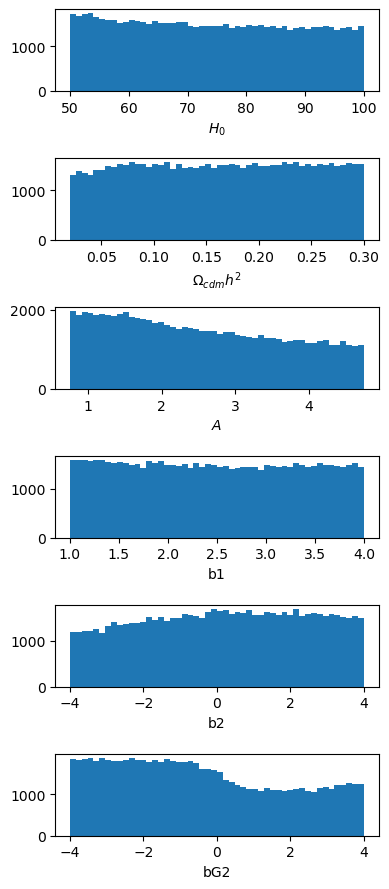

In [7]:
# check that the full set samples from the entire data range
params = test_data[:][0]
H0 = params[:,0].cpu().detach().numpy()
omch2 = params[:,1].cpu().detach().numpy()
As = params[:,2].cpu().detach().numpy()
b1 = params[:,3].cpu().detach().numpy()
b2 = params[:,4].cpu().detach().numpy()
bG2 = params[:,5].cpu().detach().numpy()

fig, ax = plt.subplots(6, figsize=(4, 9))
ax[0].hist(H0, bins=50);      ax[0].set_xlabel(r"$H_0$")
ax[1].hist(omch2, bins=50); ax[1].set_xlabel(r"$\Omega_{cdm} h^2$")
ax[2].hist(As, bins=50);   ax[2].set_xlabel(r"$A$")
ax[3].hist(b1, bins=50);      ax[3].set_xlabel(r"b1")
ax[4].hist(b2, bins=50);      ax[4].set_xlabel("b2")
ax[5].hist(bG2, bins=50);      ax[5].set_xlabel("bG2")
plt.tight_layout()

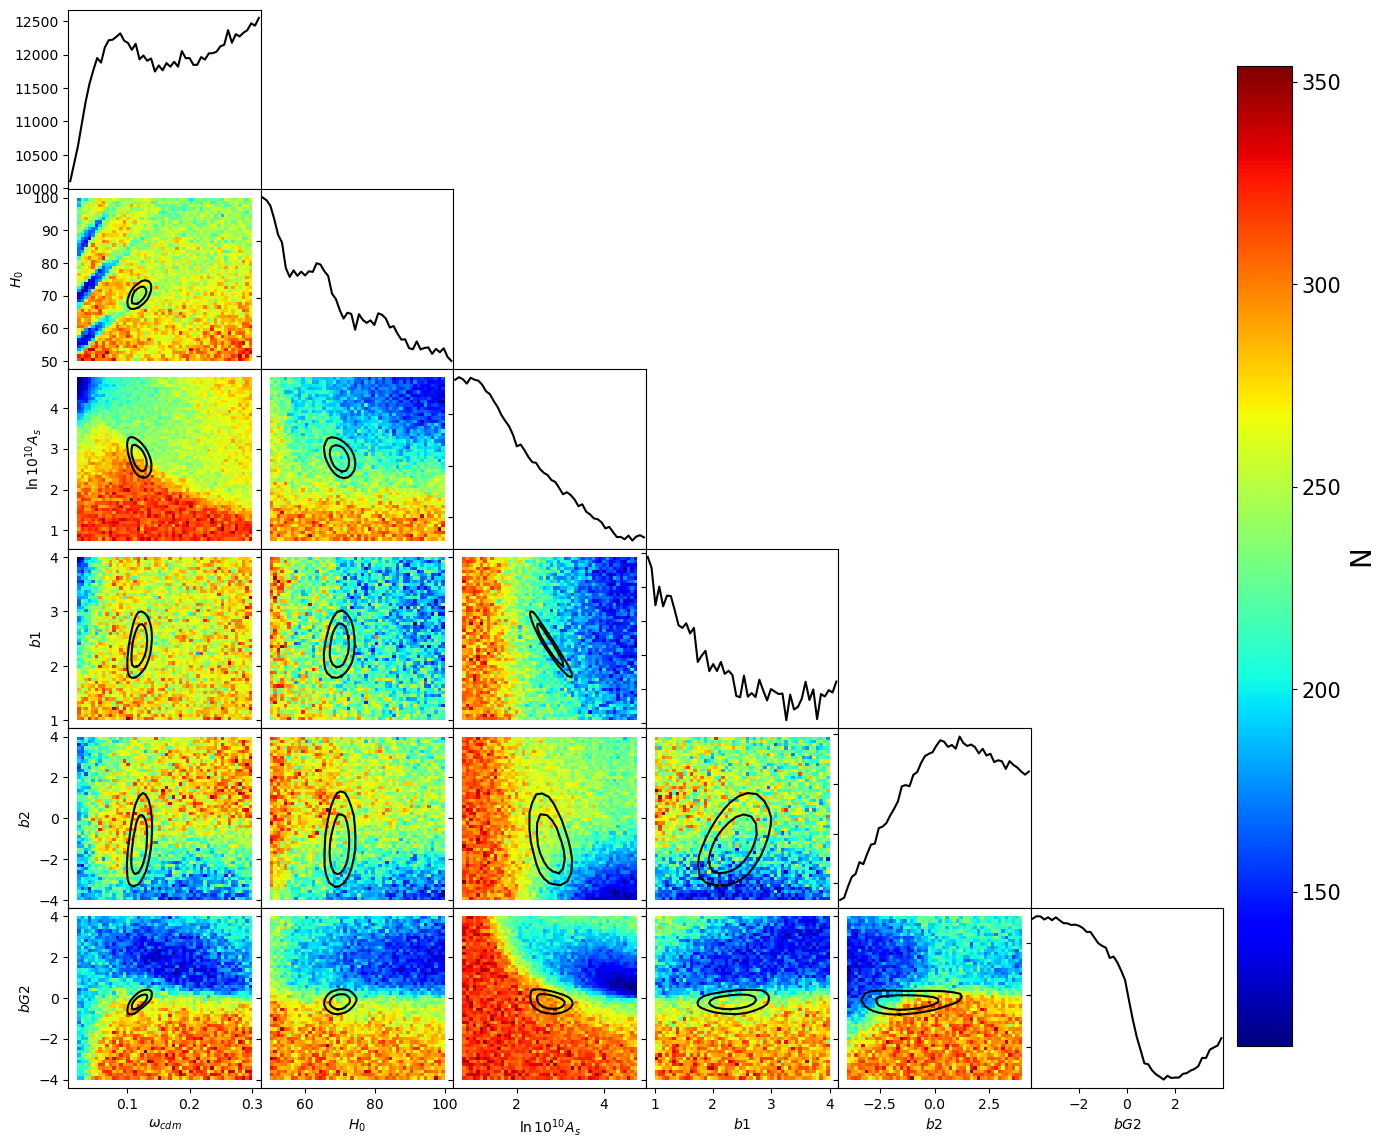

In [8]:
# visualize the distribution as a heat map

names = ['omch2', 'H0', "As", "b1", "b2", "bG2", "chi_squared"]
labels= [r'$\omega_{cdm}$', r"$H_0$", r"$\ln{10^{10} A_s}$", "$b1$", "$b2$", "$bG2$"]
#hypercube_params = np.loadtxt("/home/joeadamo/Research/CovNet/Data/Sample-params.txt", skiprows=1)
hypercube_params = np.loadtxt("/home/u12/jadamo/CovNet/Sample-params.txt", skiprows=1)
#params = hypercube_params
params = train_data[:][0].detach().numpy().copy()
params_temp = params[:,1].copy()
params[:,1] = params[:,0]
params[:,0] = params_temp

def extract_contours(name1, name2):
    file = "/home/u12/jadamo/CovNet/Plots/extracted-contours/"+name1+"-"+name2+".csv"
    contour1 = np.genfromtxt(file, skip_header=2, usecols=[0,1], delimiter=",", missing_values=",")
    contour2 = np.genfromtxt(file, skip_header=2, usecols=[2,3], delimiter=",", missing_values=",")
    return contour1, contour2

contour_bounds = np.array([[66, 70],
                           [0.09, 0.12],
                           [3, 3.6],
                           [1.6, 2.0],
                           [-4, -2.5],
                           [-0.4, 0.4]])

fig, axs = plt.subplots(6,6, figsize=(14,14))
#plt.suptitle("Training data set (N_total = 88,800)", fontsize=15)
for i in range(6):
    for j in range(6):
        if i < j:
            axs[i][j].axis("off")
            continue
        if i == j:
            hist, bin_edges = np.histogram(params[:,j], bins=50)
            width = bin_edges[1] - bin_edges[0]
            bins = np.linspace(bin_edges[0] + (width/2), bin_edges[-1] - (width/2), 50)
            axs[i][j].plot(bins, hist, c="black")
            axs[i][j].set_xlim(bin_edges[0], bin_edges[-1])
        else:
            #img = axs[i][j].scatter(params[:,j], params[:,i], c="black", s=0.1, alpha=0.5)
            img = axs[i][j].hist2d(params[:,j], params[:,i], bins=50, cmap="jet")
            
            try:
                contour1, contour2 = extract_contours(names[i], names[j])
                axs[i,j].plot(contour1[:,0], contour1[:,1], c="black")
                axs[i,j].plot(contour2[:,0], contour2[:,1], c="black")
            except:
                print("failed!")
            
            axs[i,j].set_xlim(np.amin(params[:,j]) - (np.amax(params[:,j]) - np.amin(params[:,j])) * 0.05, np.amax(params[:,j]) + (np.amax(params[:,j]) - np.amin(params[:,j])) * 0.05)
            axs[i,j].set_ylim(np.amin(params[:,i]) - (np.amax(params[:,i]) - np.amin(params[:,i])) * 0.05, np.amax(params[:,i]) + (np.amax(params[:,i]) - np.amin(params[:,i])) * 0.05)
            
        if i == 5: axs[i][j].set_xlabel(labels[j])
        if j == 0 and i != 0: axs[i][j].set_ylabel(labels[i])
        if j == 0 and i != 5:   axs[i][j].xaxis.set_ticklabels([])
        elif j != 0 and i == 5: axs[i][j].yaxis.set_ticklabels([])
        elif j != 0 and i != 5:
            axs[i][j].xaxis.set_ticklabels([])
            axs[i][j].yaxis.set_ticklabels([])

cbar_ax = fig.add_axes([0.96, 0.14, 0.039, 0.7])
cbar = fig.colorbar(img[3], cax=cbar_ax)
cbar.set_label("N" ,size=20)
cbar.ax.tick_params(labelsize=15) 
plt.subplots_adjust(wspace=0, hspace=0, right=0.95)

9930 107527479296.0


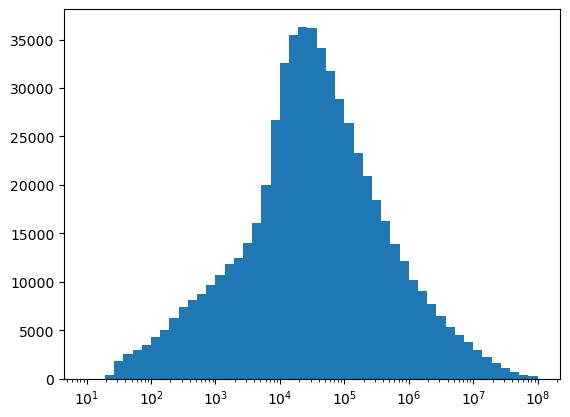

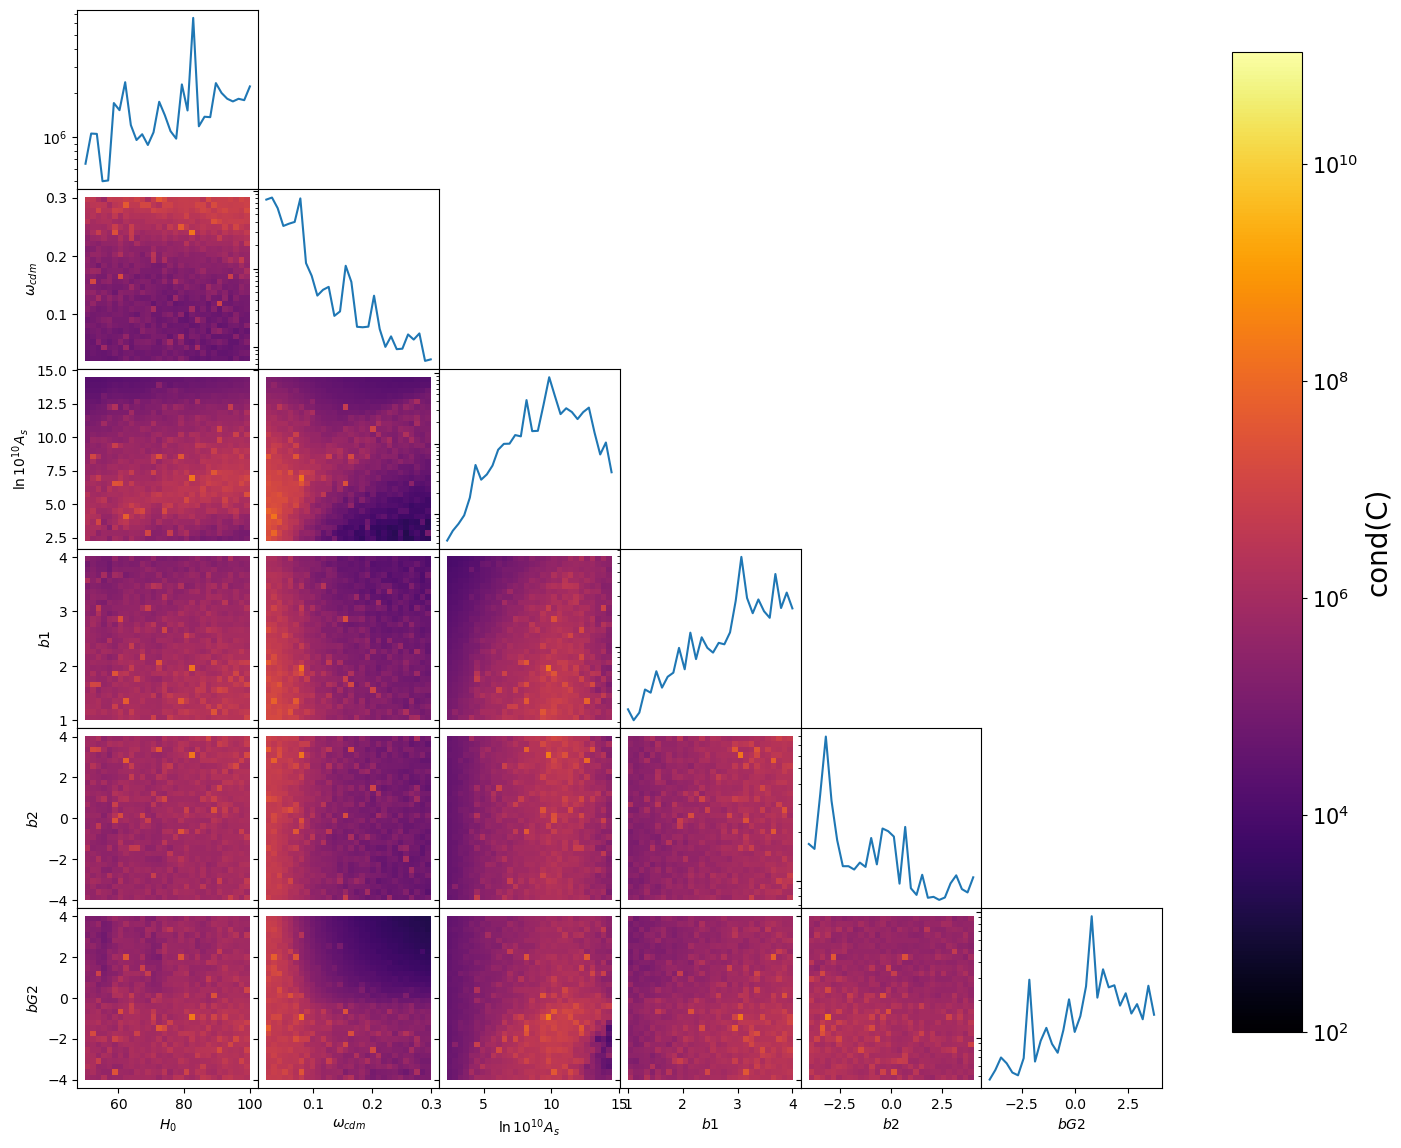

In [10]:
# visualize the condition numbers
params = train_data[:][0].detach().numpy().copy()
names = ['H0', 'omch2', "As", "b1", "b2", "bG2", "chi_squared"]
labels= [r"$H_0$", r'$\omega_{cdm}$', r"$\ln{10^{10} A_s}$", "$b1$", "$b2$", "$bG2$"]
cmap="inferno"
label=r"cond(C)"

params = params[(condition_numbers != 0)]
condition_nums = condition_numbers[(condition_numbers != 0)]

print(len(condition_nums[(condition_nums > 1e7)]), np.amax(condition_nums))

plt.figure()
plt.hist(condition_nums, bins=np.logspace(1, 8, 50))
plt.xscale("log")

def make_heatmap(x, y, z, bins):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.linspace(np.amin(y), np.amax(y), bins+1)
    z_new = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            z_new[j,i] = np.mean(z[(x >= x_new[i]) & (x < x_new[i+1]) & (y >= y_new[j]) & (y < y_new[j+1])])
    
    return x_new, y_new, z_new

def make_diagonal(x, y, bins):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.zeros(bins)
    for i in range(bins):
        y_new[i] = np.mean(y[(x >= x_new[i]) & (x <= x_new[i+1])])
    return x_new[:bins], y_new

fig, axs = plt.subplots(6,6, figsize=(14,14))
#plt.suptitle("Training data set (N_total = 88,800)", fontsize=15)
for i in range(6):
    for j in range(6):
        if i < j:
            axs[i][j].axis("off")
            continue
        if i == j:
            x, y = make_diagonal(params[:,j], condition_nums, 30)
            axs[i][j].plot(x, y)
            axs[i][j].set_yscale("log")
        else:
            X, Y, Z = make_heatmap(params[:,j], params[:,i], condition_nums, 30)
            img = axs[i,j].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]), cmap=cmap, 
                                  norm=colors.LogNorm(vmin=1e2, vmax=np.amax(condition_nums)))
            #else: img = axs[i,j].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]), cmap=cmap, vmin=extents[0], vmax=extents[1])
            axs[i,j].set_xlim(X[0] - (X[-1] - X[0]) * 0.05, X[-1] + (X[-1] - X[0]) * 0.05)
            axs[i,j].set_ylim(Y[0] - (Y[-1] - Y[0]) * 0.05, Y[-1] + (Y[-1] - Y[0]) * 0.05)
            
        if i == 5: axs[i][j].set_xlabel(labels[j])
        if j == 0 and i != 0: axs[i][j].set_ylabel(labels[i])
        if j == 0 and i != 5:   axs[i][j].xaxis.set_ticklabels([])
        elif j != 0 and i == 5: axs[i][j].yaxis.set_ticklabels([])
        elif j != 0 and i != 5:
            axs[i][j].xaxis.set_ticklabels([])
            axs[i][j].yaxis.set_ticklabels([])

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
cbar = fig.colorbar(img, cax=cbar_ax)
cbar.set_label("cond(C)" ,size=20)
cbar.ax.tick_params(labelsize=15) 
plt.subplots_adjust(wspace=0, hspace=0)

## Plots to visualize distribution of the training set data wrt mcmc chains

In [10]:
# from Likelihood.ipynb
#montepython_dir = "/xdisk/timeifler/jadamo/"
#montepython_dir = "/home/u12/jadamo/CovNet/chains/MontePython/simulated-data/"
montepython_dir = ""
names_marg=["jump factor?", " loglike", "omch2", "h", "As", "b1", "b2", "bG2", "Omega_m", "H0", "sigma8"]
As_planck = 3.0447
def load_chains(prefix, burn_in, names):
    
    all_filenames = next(os.walk(montepython_dir+prefix), (None, None, []))[2]  # [] if no file
    chain_files = []
    for i in range(len(all_filenames)):
        if ".txt" in all_filenames[i]:
            if "._" in all_filenames[i][:2]:
                #chain_files.append(all_filenames[i][2:])
                continue
            else:
                chain_files.append(all_filenames[i])
    chain_files.sort()
                
    chain_combined = np.genfromtxt(montepython_dir+prefix+chain_files[0], names=names)
    chain_combined = chain_combined[burn_in[0]:]
    for i in range(1, len(chain_files)):
        if burn_in[i] != -1:
            chain_sub = np.genfromtxt(montepython_dir+prefix+chain_files[i], names=names)
            chain_sub = chain_sub[burn_in[i]:]
            # combine all chains into one big chain
            chain_combined = np.concatenate((chain_combined, chain_sub))
    return chain_combined

In [13]:
#load_data = np.loadtxt("/home/u12/jadamo/CovNet/Inportance-Set/inportance-params.txt", skiprows=1)
load_data = load_chains("/home/u12/jadamo/CovNet/chains/MontePython/simulated-data/vary-no-determinant/", [37, -1, 20, 30, 15, 38, 14, 13], names_marg)
load_data_2 = load_chains("/xdisk/timeifler/jadamo/vary-determinant/", [190, 205, 195, 192], names_marg)

#hypercube_params = np.loadtxt("/home/joeadamo/Research/CovNet/Data/Sample-params.txt", skiprows=1)

num_in_range = 0
num_posdef = 0
num_posdef_2 = 0
params_posdef = np.array([0,0,0,0,0,0])
params_posdef_2 = np.array([0,0,0,0,0,0])

# min_data = np.amin(load_data, axis=0)
# max_data = np.amax(load_data, axis=0)
min_data = np.array([np.amin(load_data["H0"]),
                      np.amin(load_data["omch2"]),
                      np.amin(load_data["As"]),
                      np.amin(load_data["b1"]),
                      np.amin(load_data["b2"]),
                      np.amin(load_data["bG2"])])

max_data = np.array([np.amax(load_data["H0"]),
                      np.amax(load_data["omch2"]),
                      np.amax(load_data["As"]),
                      np.amax(load_data["b1"]),
                      np.amax(load_data["b2"]),
                      np.amax(load_data["bG2"])])

min_data_2 = np.array([np.amin(load_data_2["H0"]),
                      np.amin(load_data_2["omch2"]),
                      np.amin(load_data_2["As"]),
                      np.amin(load_data_2["b1"]),
                      np.amin(load_data_2["b2"]),
                      np.amin(load_data_2["bG2"])])

max_data_2 = np.array([np.amax(load_data_2["H0"]),
                      np.amax(load_data_2["omch2"]),
                      np.amax(load_data_2["As"]),
                      np.amax(load_data_2["b1"]),
                      np.amax(load_data_2["b2"]),
                      np.amax(load_data_2["bG2"])])

ratio = (max_data_2 - min_data_2) / (max_data - min_data)
V_ratio = 1.
for i in range(len(ratio)):
    V_ratio *= ratio[i]
print(V_ratio)
    
print(min_data)
for i in tqdm(range(len(train_data))):
    params = train_data[i][0].detach().numpy()
    
    if np.all(params > min_data) and np.all(params < max_data):
        num_posdef += 1
        params_posdef = np.vstack((params_posdef, params))
    if np.all(params > min_data_2) and np.all(params < max_data_2):
        num_posdef_2 += 1
        params_posdef_2 = np.vstack((params_posdef_2, params))
        
# for i in tqdm(range(hypercube_params.shape[0])):
#     params = hypercube_params[i]
    
#     if np.all(params > np.amin(load_data, axis=0)) and np.all(params < np.amax(load_data, axis=0)):
#         num_in_range += 1
#         params_in_range = np.vstack((params_in_range, params))
        
#params_in_range = params_in_range[1:, :]
params_posdef = params_posdef[1:, :]
#params_posdef_2 = params_posdef_2[1:, :]

#print("{:0.0f} sets of parameters are in the inportance region".format(num_in_range))
print("{:0.0f} matrices in inportance region are positive definite".format(num_posdef))
print("{:0.0f} matrices in second chain are positive definite".format(num_posdef_2))

0.02365833953179725
[61.42763     0.07956075  2.46746     1.334803   -2.01183    -0.8288214 ]


100%|██████████| 595987/595987 [00:26<00:00, 22899.65it/s]

1605 matrices in inportance region are positive definite
8 matrices in second chain are positive definite


(0.07984017, 0.135547)

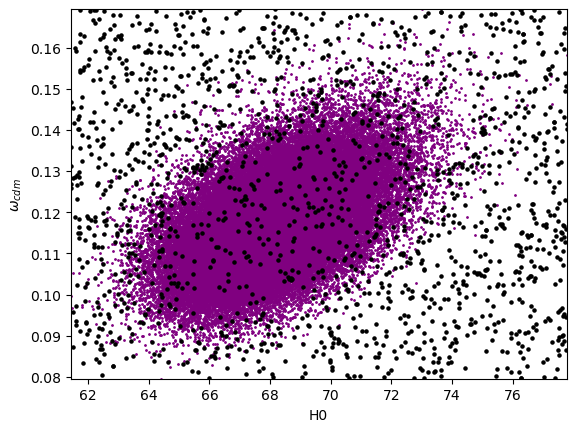

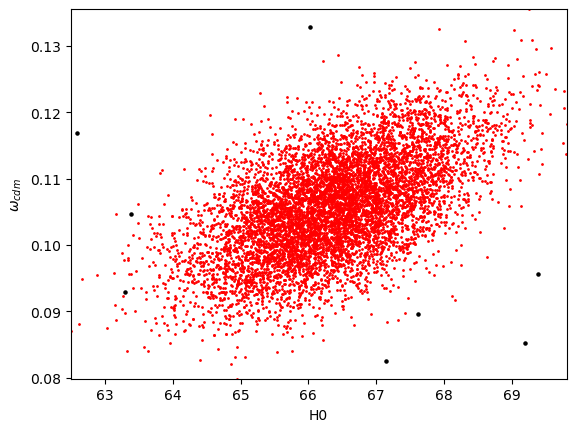

In [15]:
dim1 = 0; dim2 = 1
name1 = "H0"; name2 = "omch2"
plt.scatter(load_data[name1], load_data[name2], s=1, c="purple")
#plt.scatter(params_in_range[:,dim1], params_in_range[:,dim2], s=5, label="in training set")
plt.scatter(params_posdef[:,dim1], params_posdef[:,dim2], c="black", s=5, label="positive definite")
plt.xlabel("H0")
plt.ylabel(r"$\omega_{cdm}$")
plt.xlim(np.amin(load_data[name1]), np.amax(load_data[name1]))
plt.ylim(np.amin(load_data[name2]), np.amax(load_data[name2]))

plt.figure()
plt.scatter(load_data_2[name1], load_data_2[name2], s=1, c="red")
plt.scatter(params_posdef_2[:,dim1], params_posdef_2[:,dim2], c="black", s=5, label="positive definite")
plt.xlabel("H0")
plt.ylabel(r"$\omega_{cdm}$")
plt.xlim(np.amin(load_data_2[name1]), np.amax(load_data_2[name1]))
plt.ylim(np.amin(load_data_2[name2]), np.amax(load_data_2[name2]))

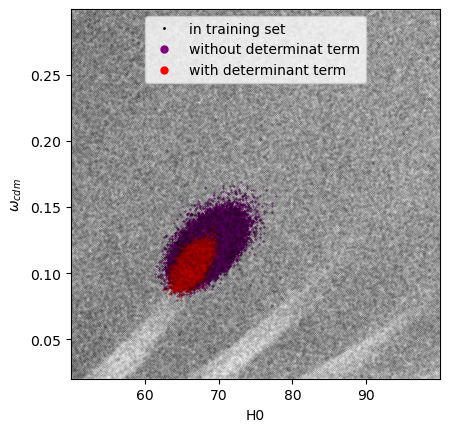

In [16]:
fix, ax = plt.subplots(1)
ax.scatter(load_data[name1], load_data[name2], s=0.1, c="purple")
ax.scatter(load_data_2[name1], load_data_2[name2], s=0.1, c="red")
ax.scatter(train_data[:][0][:,dim1], train_data[:][0][:,dim2], c="black", alpha=0.5, s=0.001)
ax.set_xlabel("H0")
ax.set_ylabel(r"$\omega_{cdm}$")
ax.set_xlim(torch.min(train_data[:][0][:,dim1]), torch.max(train_data[:][0][:,dim1]))
ax.set_ylim(torch.min(train_data[:][0][:,dim2]), torch.max(train_data[:][0][:,dim2]))
ratio = 1.0
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
legend_elements = [Line2D([0], [0], marker="o", color="black", ls="", label="in training set", markersize=1),
                   Line2D([0], [0], marker='o', color="purple", ls="", label='without determinat term', markersize=5),
                   Line2D([0], [0], marker="o", color="red", ls="", label="with determinant term", markersize=5)]
ax.legend(handles=legend_elements, loc="upper center")
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

In [ ]:
train_data = None
full_data = np.load(training_dir+"CovA-training.npz")
params = full_data["params"]
C_G = full_data["C_G"]
C_NG = full_data["C_NG"]

# cut out 90% of the data
# this should let me run on my laptop
N = params.shape[0]
N_small = int(N * 0.1)
print("Saving", N_small, "matrices...")

params = params[:N_small, :]
C_G = C_G[:N_small, :,:]
C_NG = C_NG[:N_small, :,:]

np.savez(training_dir+"CovA-training-small.npz", params=params, C_G=C_G, C_NG=C_NG)
print("Done!")

Saving 59598 matrices...
Done!


### Data pre-processing code  
The following cells exist to test several different pre-processing methods for the covariance matrix

tensor([55.8036,  0.1022,  1.5248,  3.3097,  2.7118, -1.5698])
tensor(13312.)


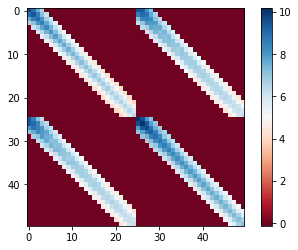

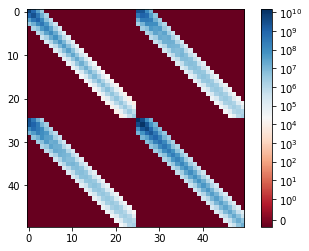

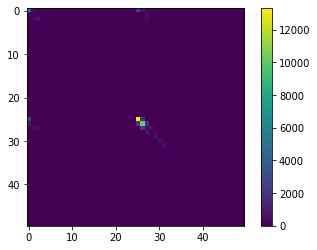

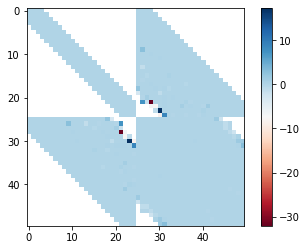

In [13]:
# test the logarithm function and make sure exp(log(C)) = C
idx = np.random.randint(0, N)
C = torch.from_numpy(all_data.get_full_matrix(idx))
C = C.to(torch.float32)
params = all_data[idx][0]
print(params)
C_log = CovNet.symmetric_log(C); C_1 = CovNet.symmetric_exp(C_log)
# C and C_1 should be equal, so C - C_1 should just be a matrix of all zeros
max_diff = torch.max(abs((C - C_1)))
print(max_diff)
# plt.imshow(C - C_1, cmap="RdBu")
# cbar = plt.colorbar()

plt.figure()
plt.imshow(C_log, cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
m = plt.imshow(C_1, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1.))
cbar = plt.colorbar()

plt.figure()
plt.imshow(abs(C_1 - C))
cbar = plt.colorbar()

plt.figure()
plt.imshow(100*(C_1 - C) / C, cmap="RdBu")
cbar = plt.colorbar()

In [20]:
C = all_data[idx][1].view(1,50,50)
C_0 = all_data[idx+1][1].view(1,50,50)
C = torch.cat((C, C_0), 0)
C_2 = all_data.get_full_matrix(idx)
C_3 = all_data.get_full_matrix(idx+1)

Det_predict = 2*torch.sum(torch.log(torch.diagonal(CovNet.symmetric_exp(C), dim1=1, dim2=2)))
Det_actual = np.linalg.slogdet(C_2)[1] + np.linalg.slogdet(C_3)[1]
print(Det_predict, Det_actual)

tensor(1849.8190) 1849.819


tensor(2739.8652) tensor(3.4379) tensor(2739.8652)


<Figure size 432x288 with 0 Axes>

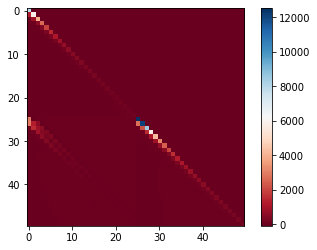

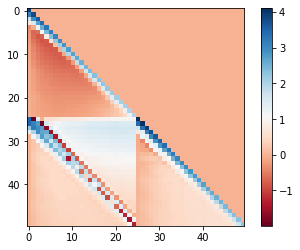

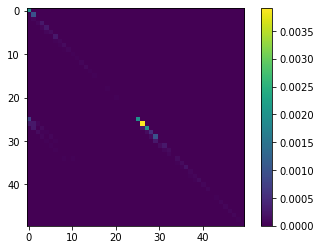

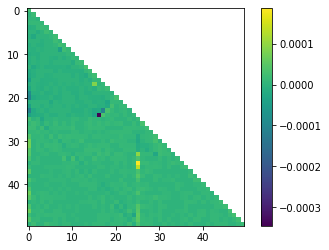

In [7]:
L = torch.linalg.cholesky(C)

#L = CovNet.rearange_to_half(L, 50).view(51, 25)
L_log = CovNet.symmetric_log(L)
L_2 = CovNet.symmetric_exp(L_log)

diff = abs(L - L_2)
idx_diff = torch.where(diff > 0)
print(L[26,25], L_log[26,25], L_2[26,25])

plt.figure()
C_sinh = np.arcsinh(C)
C_2 = np.sinh(C_sinh)
plt.figure()
plt.imshow(L, cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow(L_log, cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow(abs(L_2 - L))
cbar = plt.colorbar()

plt.figure()
plt.imshow(100*abs(L_2 - L) / L)
cbar = plt.colorbar()

## PCA Code

In [100]:
# find the PCA reconstruction error for a given number of PCs

min_v, max_v = test_data.do_PCA(250, training_dir)

def PCA_error(data, num_pc, noise_amount=1.):
    if os.path.exists("./pca.pkl"):
        os.remove("./pca.pkl")
    #min_v, max_v = data.do_PCA(num_pc)
    variance = np.cumsum(data.pca.explained_variance_ratio_)[-1]
    weight = torch.flip(torch.arange(0, 500, 2), (0,)) / 500
    
    loss = 0
    error = torch.zeros(len(data))
    for i in tqdm(range(len(data))):
        if noise_amount != 1.:
            #noise_vector = ((torch.rand(num_pc) - 0.5) * noise_amount * weight).detach()
            #comp = data.components[i] + noise_vector
            #error[i] = torch.mean(abs(noise_vector / data.components[i])).detach()
            comp = torch.clone(data.components[i]).detach()
            noise_value = (torch.rand(1) - 0.5) * noise_amount
            comp[0] = comp[0] + noise_value
            error[i] = abs(noise_value / data.components[i][0])
        else:
            comp = data.components[i]
        C = CovNet.reverse_pca(comp, data.pca, min_v, max_v).view(1, 51, 25)
        C = CovNet.rearange_to_full(C, 50, True).view(50,50)
        C2 = CovNet.reverse_pca(data.components[i], data.pca, min_v, max_v).view(1, 51, 25)
        C2 = CovNet.rearange_to_full(C2, 50, True).view(50,50)
        loss += F.l1_loss(C, C2, reduction="sum").item()
        
    idx = torch.where(torch.isinf(error) == False)
    return loss / len(data), variance, torch.mean(error[idx])

def PCA_net_error(data, num_pc, net):
#     if os.path.exists("./pca.pkl"):
#         os.remove("./pca.pkl")
    #min_v, max_v = data.do_PCA(num_pc)
    variance = np.cumsum(data.pca.explained_variance_ratio_)[-1]
    
    loss_full = 0
    loss_sub = 0
    error = torch.zeros((len(data), 250))
    for i in tqdm(range(len(data))):
        #noise_vector = ((torch.rand(num_pc) - 0.5) * noise_amount * weight).detach()
        #comp = data.components[i] + noise_vector
        #error[i] = torch.mean(abs(noise_vector / data.components[i])).detach()
        comp = torch.clone(data.components[i]).detach()
        comp_net = net(data[i][0].view(1,6)).view(250)
        comp[0] = comp_net[0]
        error[i] = (comp_net - data.components[i]) / data.components[i]

        C = CovNet.reverse_pca(comp, data.pca, min_v, max_v).view(1, 51, 25)
        C = CovNet.rearange_to_full(C, 50, True).view(50,50)
        
        C2 = CovNet.reverse_pca(data.components[i], data.pca, min_v, max_v).view(1, 51, 25)
        C2 = CovNet.rearange_to_full(C2, 50, True).view(50,50)
        loss_full += F.l1_loss(C, data[i][1], reduction="sum").item()
        loss_sub += F.l1_loss(C, C2, reduction="sum").item()
        
    #idx = torch.where(torch.isinf(error) == False)
    return loss_full / len(data), loss_sub / len(data), error

def get_PCA(data, num_pc):
    if os.path.exists("./pca.pkl"):
        os.remove("./pca.pkl")
    min_v, max_v = data.do_PCA(num_pc)
    return data.pca

In [61]:
weight = torch.flip(torch.arange(0, 500, 2), (0,)) / 500
noise_vector = (torch.rand(250) - 0.5) * 0.01 * weight
components = test_data.components[38546]

# print(torch.mean(abs(noise_vector / components)))

# print(torch.sum(abs(noise_vector)))
# plt.plot(components, linewidth=2)
# plt.plot(components + noise_vector)

loss = torch.zeros(15)
error = torch.zeros(15)
noise_amount = torch.logspace(-4, -1, 15)
print(noise_amount)
for i in range(15):
    loss[i], variance, error[i] = PCA_error(test_data, 250, noise_amount[i])
    # print(loss, error)

# pc_numbers = np.linspace(100, 600, 40)
# pc_loss = np.zeros(40)
# variance = np.zeros(40)
# for i in range(len(pc_numbers)):
#     pc_loss[i], variance[i] = PCA_error(test_data, int(pc_numbers[i]))

# print(pc_loss)

tensor([1.0000e-04, 1.6379e-04, 2.6827e-04, 4.3940e-04, 7.1969e-04, 1.1788e-03,
        1.9307e-03, 3.1623e-03, 5.1795e-03, 8.4834e-03, 1.3895e-02, 2.2758e-02,
        3.7276e-02, 6.1054e-02, 1.0000e-01])


100%|██████████| 65872/65872 [01:24<00:00, 777.70it/s]


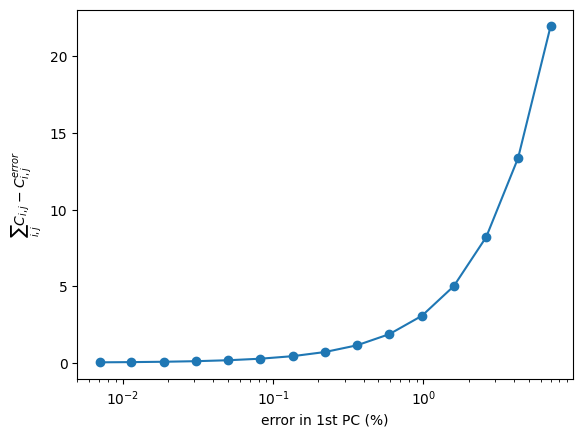

In [62]:
# plt.plot(error * 100, loss, marker="o")
# plt.scatter(0.0042 * 100, 21.868, c="black")
# plt.xlabel("average error per PC (%)")
# plt.ylabel("Average L1 loss")
# plt.xscale("log")

plt.plot(error*100, loss, marker="o")
plt.xlabel("error in 1st PC (%)")
plt.ylabel(r"$\sum_{i,j} C_{i,j} - C_{i,j}^{error}$")
plt.xscale("log")

# fig, axs = plt.subplots(2, 1, sharex=True, height_ratios=[2,1])
# axs[0].plot(pc_numbers, pc_loss)
# axs[0].axhline(5.77, ls="--", c="black", label="MLP netowrk loss")
# axs[1].plot(pc_numbers, variance)
# axs[1].set_xlabel("number of PCs")
# axs[0].set_ylabel("Average L1 Loss")
# axs[1].set_ylabel("Explained Variance")
# axs[0].set_xlim(100, 600)
# axs[0].legend()
# plt.subplots_adjust(hspace=0)

tensor(0.0013, dtype=torch.float64)


100%|██████████| 65872/65872 [03:53<00:00, 282.00it/s]


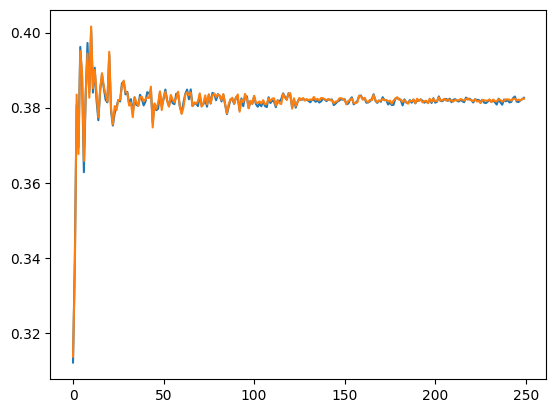

In [101]:
net_dir = "/home/u12/jadamo/CovNet/emulators/ngc_z3/MLP-PCA/"
net = CovNet.Network_Emulator("MLP-PCA").to(torch.device("cpu"));       net.eval()
net.load_state_dict(torch.load(net_dir+'network.params', map_location=torch.device('cpu')))

idx = np.random.randint(len(test_data))
params = test_data[idx][0].view(1, 6)
components = test_data.components[idx]
components_net = net(params).view(250).detach()

plt.plot(components)
plt.plot(components_net)

print(torch.mean(abs((components_net - components) / components)))
loss_full, loss_mean, error = PCA_net_error(test_data, 250, net)

total loss = 8.642, loss from just 1st PC error = 5.241, average error on 1st PC = 1.620%


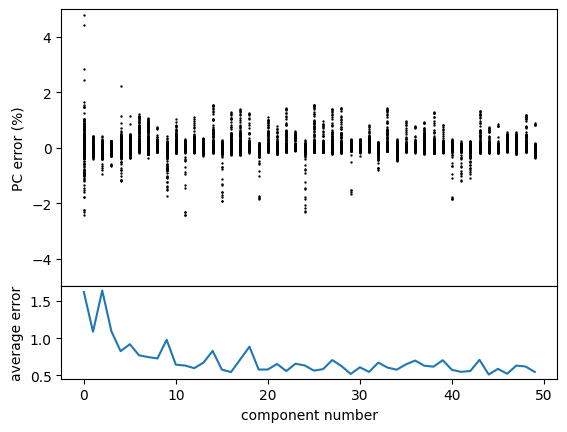

In [107]:
error_1 = 100*torch.mean(abs(error[:,0]))

print("total loss = {:0.3f}, loss from just 1st PC error = {:0.3f}, average error on 1st PC = {:0.3f}%".format(
    loss_full, loss_mean, error_1))

fix, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
for i in range(50):
    axs[0].scatter(np.ones(len(test_data))*i, error[:,i].detach(), c="black", s=0.5)
mean_error = 100*torch.mean(abs(error), dim=0).detach()
axs[1].plot(range(50), mean_error[:50])
    
axs[0].set_ylim(-5, 5)
axs[1].set_xlabel("component number")
axs[0].set_ylabel("PC error (%)")
axs[1].set_ylabel("average error")
plt.subplots_adjust(hspace=0)